In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import networkx as nx
import pandas as pd
import numpy as np
import scipy.stats as stats
sys.path.insert(0, Path.cwd().absolute())

BASE_DIR = (Path.cwd()).parent

In [2]:
from network_analysis.flow_assignment import FlowAssignment
from network_analysis.geodf_network import GeoDataNetwork
from geoprocessing.faf_zone_network import FafZoneNetwork, normalize_reverse, apply_to_network
from network_analysis.mc_flow_assignment import sample_flows
import geopandas as gpd

In [3]:
SIMPLE_NET = False # (421, 423, 341, 342 )

MONTE_CARLO = False
MC_ITER_N = 500
NORMAL_DIST = True

COLUMN = 'thousand tons in 2035'

# Validations
if SIMPLE_NET:
  MONTE_CARLO = False
  

In [4]:
naRailNodesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Nodes")
naRailLinesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Lines")
fafZonesDf = gpd.read_file( BASE_DIR / "inputs/faf_zones_exploded").to_crs(4326)


In [5]:
fzn = FafZoneNetwork(naRailNodesDf, naRailLinesDf, fafZonesDf).setInputDfColType()
faf_flows = pd.read_csv(Path.cwd().parent / 'inputs/faf_freight_flow_exploded.csv' )
railnet = fzn.createNetwork()

fa = FlowAssignment(railnet)

railnet_flows = fa(faf_flows, SUM_COLUMN=COLUMN) # For comparison, if Monte Carlo mode

In [6]:
# fzn.fafZoneNodesDf['node_degree'] = dict(railnet.degree())
# fzn.fafZoneNodesDf['node_degree'] = fzn.fafZoneNodesDf['node_degree'].dropna().astype(int)
# fzn._fafZoneLinksDf = None

# def link_weights(df : gpd.GeoDataFrame):
#   df['centrality'] = dict(nx.edge_betweenness_centrality(railnet))
#   # for segment, centrality in dict(nx.edge_betweenness_centrality(railnet)).items():

#   df['distance'] = df['geometry_fr'].to_crs(3857).distance(df['geometry_to'].to_crs(3857))
#   df['distance_norm'] = normalize_reverse(df['distance'])
#   df['n_tracks_norm'] = normalize_reverse(df['FRAARCID'])
#   df['avg_node_degree'] = (df['node_degree_fr'] + df['node_degree_to']) / 2
#   return df['centrality']
# fzn.network_weight_fn = link_weights

# railnet = fzn.createNetwork()

In [7]:
fa = FlowAssignment(railnet)

railnet_flows = fa(faf_flows, SUM_COLUMN=COLUMN) # For comparison, if Monte Carlo mode

if not MONTE_CARLO:
  fzn.apply_flows(railnet_flows.to_dict())
  # fzn.apply_flows(link_weights(fzn.fafZoneLinksDf))
if MONTE_CARLO:
  monte_railnet_flows = []
  monte_inputs = []
  for i in range(MC_ITER_N):
    iteration_inputs = sample_flows(faf_flows, COLUMN, distribution='normal' if NORMAL_DIST else 'triangular')
    monte_inputs.append(iteration_inputs)
    faf_flows['input_flows'] = iteration_inputs
    iteration_flow = fa.run(faf_flows, SUM_COLUMN='input_flows')
    monte_railnet_flows.append(iteration_flow)
  monte_railnet_flows = pd.concat(monte_railnet_flows, axis=1)
  monte_railnet_flows.columns=range(MC_ITER_N)
  fzn.fafZoneLinksDf['flows'] = monte_railnet_flows.mean(axis=1)
  fzn.fafZoneLinksDf['flow_covs'] = monte_railnet_flows.std(axis=1) / monte_railnet_flows.mean(axis=1)
  railnet_flows.index = railnet_flows.index.set_names({'seg_start':'FAF_Zone_fr', 'seg_end':'FAF_Zone_to'})
  fzn.fafZoneLinksDf['flow_df'] = (fzn.fafZoneLinksDf['flows'] - railnet_flows).abs()
  fzn.fafZoneLinksDf['flow_df_percent'] = fzn.fafZoneLinksDf['flow_df'] / railnet_flows

In [17]:
faf_geonet = GeoDataNetwork(
  fzn.fafZoneNodesDf.copy(),
  fzn.fafZoneLinksDf.copy(),
  'FAF_Zone_1',
  lambda df : df['flows'],
  # lambda df : 0,
  lambda df : df.reset_index().set_index(['FAF_Zone_fr', 'FAF_Zone_to'], drop=False)[['FAF_Zone_fr', 'FAF_Zone_to']],
  VALUE='centrality'
)

faf_geonet.calculate_centrality()
faf_railnet = faf_geonet.createNetwork(NAME='FAF')
faf_geonet.create_normalizers(stats.uniform, stats.uniform)
display(faf_geonet.show_map())
faf_geonet.show_values()

,FAF_Zone_1,centrality
FAF_Zone,,
11,"Birmingham-Hoover-Talladega, AL CFS Area",0.000000
12,"Mobile-Daphne-Fairhope, AL CFS Area",0.000000
19,Remainder of Alabama,0.027795
41,"Phoenix-Mesa-Scottsdale, AZ CFS Area",0.014321
42,"Tucson-Nogales, AZ CFS Area",0.000000
...,...,...
3399,Remainder of Ohio,0.042685
3479,Remainder of Tennessee,0.293954
4069,Remainder of California,0.014321


FAF_Zone_1_fr  \
FAF_Zone_fr FAF_Zone_to                                                      
11          19                   Birmingham-Hoover-Talladega, AL  CFS Area   
12          19                        Mobile-Daphne-Fairhope, AL  CFS Area   
            280                       Mobile-Daphne-Fairhope, AL  CFS Area   
            4129                      Mobile-Daphne-Fairhope, AL  CFS Area   
19          131                                       Remainder of Alabama   
...                                                                    ...   
531         539                               Seattle-Tacoma, WA  CFS Area   
532         539          Portland-Vancouver-Salem, OR-WA  CFS Area (WA ...   
540         2399                                             West Virginia   
551         559                    Milwaukee-Racine-Waukesha, WI  CFS Area   
1479        3379                                    Remainder of Tennessee   

                                                             FAF_Zone_1_to  \
FAF_Zone_fr FAF_Zone_to                                                      
11          19                                        Remainder of Alabama   
12          19                                        Remainder of Alabama   
            280                                                Mississippi   
            4129                                      Remainder of Florida   
19          131          Atlanta-Athens-Clarke County-Sandy Springs, GA...   
...                                                                    ...   
531         539                                    Remainder of Washington   
532         539                                    Remainder of Washington   
540         2399                                         Remainder of Ohio   
551         559                                   Remainder of Wisconsin\r   
1479        3379                               Remainder of North Carolina   

                         centrality  
FAF_Zone_fr FAF_Zone_to              
11          19             0.014219  
12          19             0.013489  
            280            0.000000  
            4129           0.000730  
19          131            0.000000  
...                             ...  
531         539            0.000000  
532         539            0.042032  
540         2399           0.203420  
551         559            0.022287  
1479        3379           0.248788  

[275 rows x 3 columns]

In [19]:
faf_geonet = GeoDataNetwork(
  fzn.fafZoneNodesDf.copy(),
  fzn.fafZoneLinksDf.copy(),
  'FAF_Zone_1',
  lambda df : 0,
  # lambda df : 0,
  lambda df : df.reset_index().set_index(['FAF_Zone_fr', 'FAF_Zone_to'], drop=False)[['FAF_Zone_fr', 'FAF_Zone_to']],
  VALUE='flows'
)

faf_geonet.calculate_centrality()
faf_railnet = faf_geonet.createNetwork(NAME='FAF')
faf_geonet.create_normalizers(stats.genexpon, stats.uniform)
display(faf_geonet.show_map())
faf_geonet.show_values()

,FAF_Zone_1,flows
FAF_Zone,,
11,"Birmingham-Hoover-Talladega, AL CFS Area",2.236290e+05
12,"Mobile-Daphne-Fairhope, AL CFS Area",3.630320e+05
19,Remainder of Alabama,1.217408e+06
20,Alaska,0.000000e+00
41,"Phoenix-Mesa-Scottsdale, AZ CFS Area",3.968520e+04
...,...,...
3399,Remainder of Ohio,8.303011e+05
3479,Remainder of Tennessee,3.039989e+05
4069,Remainder of California,6.984260e+06


FAF_Zone_1_fr  \
FAF_Zone_fr FAF_Zone_to                                                      
11          19                   Birmingham-Hoover-Talladega, AL  CFS Area   
12          19                        Mobile-Daphne-Fairhope, AL  CFS Area   
            280                       Mobile-Daphne-Fairhope, AL  CFS Area   
            4129                      Mobile-Daphne-Fairhope, AL  CFS Area   
19          131                                       Remainder of Alabama   
...                                                                    ...   
531         539                               Seattle-Tacoma, WA  CFS Area   
532         539          Portland-Vancouver-Salem, OR-WA  CFS Area (WA ...   
540         2399                                             West Virginia   
551         559                    Milwaukee-Racine-Waukesha, WI  CFS Area   
1479        3379                                    Remainder of Tennessee   

                                                             FAF_Zone_1_to  \
FAF_Zone_fr FAF_Zone_to                                                      
11          19                                        Remainder of Alabama   
12          19                                        Remainder of Alabama   
            280                                                Mississippi   
            4129                                      Remainder of Florida   
19          131          Atlanta-Athens-Clarke County-Sandy Springs, GA...   
...                                                                    ...   
531         539                                    Remainder of Washington   
532         539                                    Remainder of Washington   
540         2399                                         Remainder of Ohio   
551         559                                   Remainder of Wisconsin\r   
1479        3379                               Remainder of North Carolina   

                                 flows  
FAF_Zone_fr FAF_Zone_to                 
11          19           447258.000000  
12          19            67202.666667  
            280          283052.952381  
            4129         375808.333333  
19          131          377160.000000  
...                                ...  
531         539          320722.000000  
532         539          150156.250000  
540         2399          12327.428571  
551         559           68704.000000  
1479        3379            206.850000  

[275 rows x 3 columns]

,FAF_Zone_1_fr,FAF_Zone_1_to,flowr
0,Remainder of Illinois,Remainder of Kentucky,0.0
1,Remainder of Illinois,Remainder of Missouri,0.0
2,Remainder of New York,Remainder of Pennsylvania,0.0
3,Remainder of Kentucky,West Virginia,0.0
4,Remainder of Kentucky,Remainder of Ohio,0.0
5,"Albany-Schenectady, NY CFS Area",Remainder of New York,0.0
6,Remainder of Pennsylvania,West Virginia,0.0
7,Remainder of Illinois,Iowa,0.0
8,Remainder of Arizona,New Mexico,0.0
9,Remainder of Pennsylvania,Remainder of Ohio,0.0


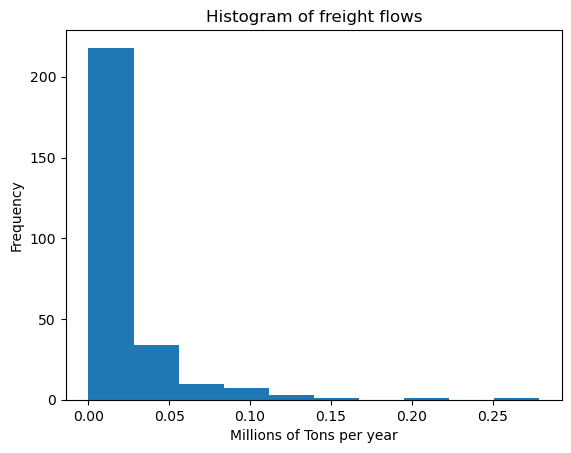

In [ ]:
import matplotlib.pyplot as plt

import folium
import branca.colormap as cm
from IPython.display import display


min_lat=24.7433195
max_lat=49.3457868
min_lon=-124.7844079
max_lon=-66.9513812


m = folium.Map(
  max_bounds=True,
  location=[42, -95],
  zoom_start=4,
  min_zoom=4,
  tiles='OpenStreetMap',
  # max_lat=max_lat,
  # min_lon=min_lon,
  # max_lon=max_lon,
  # min_lat=min_lat
)


# flows.apply(distrib.cdf).plot(kind='hist', bins=50)

m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

lineWeightMax = 5
lineWeightMin = 0.5

if True:
  zoneDf = fzn.fafZonesDf.copy()
  zoneDf.geometry = zoneDf.geometry.simplify(.15)
  zoneDf[['FAF_Zone_1', 'geometry']].explore(
    m=m,
    column='FAF_Zone_1',
    cmap='Greens',
    legend=False,
    style_kwds={'opacity':.1}
  )

if False: 
  from folium import DivIcon
  for i, r in fzn.fafZoneLinksDf.iterrows():
    center = r.geometry.centroid
    folium.map.Marker(
      [center.y, center.x],
      icon=DivIcon(
          icon_size=(20,150),
          icon_anchor=(0,0),
          html='<div style="font-size: 12px">%s</div>' % round(r.flows,4),
        )
    ).add_to(m)


  for i, r in fzn.fafZoneNodesDf.iterrows():
    center = r.geometry.centroid
    folium.map.Marker(
      [center.y, center.x],
      icon=DivIcon(
          icon_size=(20,150),
          icon_anchor=(0,0),
          html='<div style="font-size: 16px; font-weight: bold">%s</div>' % int(i),
        )
    ).add_to(m)

get_flow = lambda feature : feature['properties']['flows']
fzn.fafZoneLinksDf[['FAF_Zone_1_fr', 'FAF_Zone_1_to', 'flows', 'geometry']].explore(
  m=m,
  column='flows',
  style_kwds={
    'style_function': lambda feature: {
      'color': cm.linear.plasma(link_normalizer(get_flow(feature))),
      'weight': link_normalizer(get_flow(feature)) * (lineWeightMax - lineWeightMin) + lineWeightMin
    }
  },
  legend=True,
  legend_kwds={
    'legend_name': 'Tons of Freight Transported',
  }
)


fzn.fafZoneNodesDf[['FAF_Zone_1', 'flows', 'geometry']].explore(
  m=m,
  color='black',
  # column='flows',
  style_kwds={
    'style_function': lambda feature: {
      # 'color': cm.linear.plasma(norm_w(feature)),
      'weight': node_normalizer(get_flow(feature)) * (lineWeightMax - lineWeightMin) + lineWeightMin
    }
  }
)
display(m)
if MONTE_CARLO:
  fzn.fafZoneLinksDf['flow_df%'] = (fzn.fafZoneLinksDf['flow_df_percent'] * 100).round(2)
fzn.fafZoneLinksDf['flowr'] = fzn.fafZoneLinksDf['flows'].round()

display(fzn.fafZoneLinksDf.sort_values('flows', axis=0, ascending=False).reset_index()[
  ['FAF_Zone_1_fr', 'FAF_Zone_1_to', 'flowr'] + (['flow_df%', 'flow_covs', 'flow_df', ] if MONTE_CARLO else [])
].head(10))
fzn.fafZoneLinksDf['flows'].plot(
  kind='hist',
  title='Histogram of freight flows',
  xlabel='Millions of Tons per year'
)
plt.show()

if MONTE_CARLO:
  from matplotlib.ticker import PercentFormatter

  diff_percents = monte_railnet_flows.sub(railnet_flows, axis=0).abs().div(railnet_flows, axis=0).mul(100, axis=0)
  plot = diff_percents.T.expanding().mean().abs().mean(axis=1).plot(
    title='Monte Carlo Simulation Convergence',
    xlabel='Iterations',
    ylabel='Precent Error'
  )
  plot.yaxis.set_major_formatter(PercentFormatter())
  plt.show()
  avg_diff_percents = diff_percents.mean(axis=1)
  fzn.fafZoneLinksDf.loc[~np.isfinite(fzn.fafZoneLinksDf.flow_df_percent), 'flow_df_percent'] = 0
  plot = avg_diff_percents.plot(
    kind='hist',
    title='Histogram of flow errors in percent',
    xlabel='Percent Error'
  )
  mean_error = avg_diff_percents.mean()
  plt.axvline(mean_error, color='k')
  plot.xaxis.set_major_formatter(PercentFormatter())
  
  min_ylim, max_ylim = plt.ylim()
  plt.text(mean_error * 1.1, max_ylim*0.9, 'Mean: {:.4f}%'.format(mean_error))
  plt.show()